# Basic Trajectory Inference

Diffusion maps were introduced by Ronald Coifman and Stephane Lafon, and the underlying idea is to assume that the data are samples from a diffusion process.

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

Note that both methods require the input of cells in their initial state, and we will introduce other methods that do not require the input of artificial information, such as pyVIA, in subsequent analyses.


## Preprocess data

As an example, we apply differential kinetic analysis to pancrea development.

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import omicverse as ov
ov.plot_set(font_path='Arial')


%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.9rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



In [2]:
adata=ov.datasets.pancreatic_endocrinogenesis()

🔍 Downloading data to ./data/endocrinogenesis_day15.h5ad
⚠️ File ./data/endocrinogenesis_day15.h5ad already exists
 Loading data from ./data/endocrinogenesis_day15.h5ad
✅ Successfully loaded: 3696 cells × 27998 genes


In [3]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

🔍 [2026-01-08 01:46:59] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 17750/27998 genes are kept.
    Among 17750 genes, 16426 genes are robust.
✅ Robust gene identification completed successfully.
Begin size normalization: shiftlog and HVGs selection pearson

🔍 Count Normalization:
   Target sum: 500000.0
   Exclude highly expressed: True
   Max fraction threshold: 0.2
   ⚠️ Excluding 1 highly-expressed genes from normalization computation
   Excluded genes: ['Ghrl']

✅ Count Normalization Completed Successfully!
   ✓ Processed: 3,696 cells × 16,426 genes
   ✓ Runtime: 0.26s

🔍 Highly Variable Genes Selection (Experimental):
   Method: pearson_residuals
   Target genes: 3,000
   Theta (overdispersion): 100

✅ Experimental HVG Selection Completed Successfully!
   ✓ Selected: 3,000 highly variable genes out of 16,426 total (18.3%)
   ✓ Results added to AnnData object:
     • 'highly_variable': Boolean vector (adata.var)
     • 'highly_vari

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells. In our experience, often a rough estimate of the number of PCs does fine.

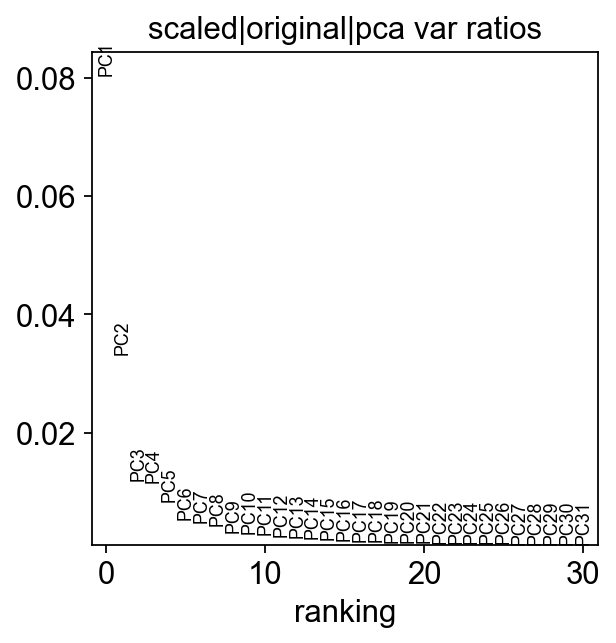

In [4]:
ov.utils.plot_pca_variance_ratio(adata)

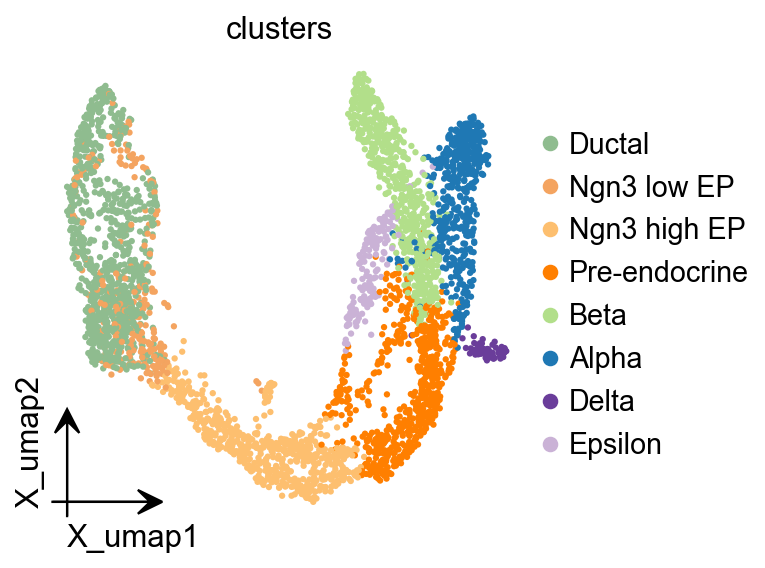

In [6]:
ov.pl.umap(
    adata,
    color='clusters'
)

## Diffusion map

Here, we used `ov.single.TrajInfer` to construct a Trajectory Inference object.

In [7]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',groupby='clusters',
                         use_rep='scaled|original|X_pca',n_comps=50,)
Traj.set_origin_cells('Ductal')

In [8]:
Traj.inference(method='diffusion_map')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9987905  0.99214125 0.98651093 0.97781146 0.9722542
     0.96662146 0.960493   0.9567027  0.9539689  0.9509432  0.94738775
     0.9382746  0.9368901  0.923836  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)
computing Diffusion 

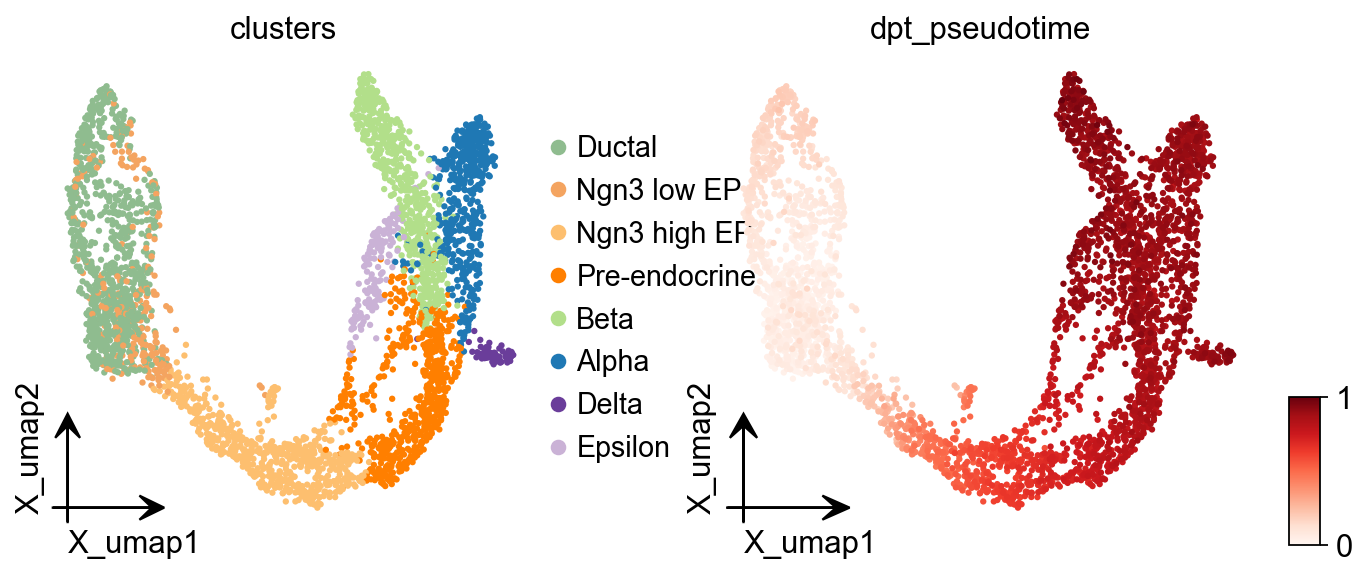

In [10]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','dpt_pseudotime'],
                   frameon='small',cmap='Reds')

PAGA graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. 

Here, PAGA is extended by neighbor directionality.

In [11]:
ov.utils.cal_paga(adata,use_time_prior='dpt_pseudotime',vkey='paga',
                 groups='clusters')

running PAGA using priors: ['dpt_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<Axes: title={'center': 'PAGA DPT-graph'}>

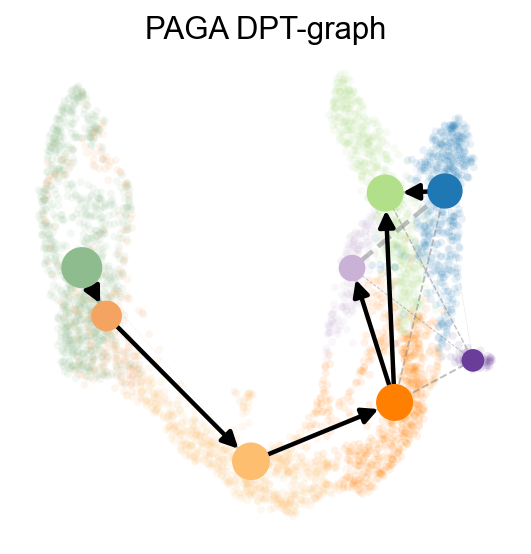

In [13]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA DPT-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## Slingshot

Provides functions for inferring continuous, branching lineage structures in low-dimensional data. Slingshot was designed to model developmental trajectories in single-cell RNA sequencing data and serve as a component in an analysis pipeline after dimensionality reduction and clustering. It is flexible enough to handle arbitrarily many branching events and allows for the incorporation of prior knowledge through supervised graph construction.

In [14]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',groupby='clusters',
                         use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('Ductal')
#Traj.set_terminal_cells(["Granule mature","OL","Astrocytes"])

If you only need the proposed timing and not the lineage of the process, then you can leave the debug_axes parameter unset.

In [16]:
Traj.inference(method='slingshot',num_epochs=1)

Lineages: [Lineage[3, 6, 5, 7, 1, 0], Lineage[3, 6, 5, 7, 1, 4], Lineage[3, 6, 5, 7, 2]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b434610>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b437ac0>]
Averaging branch @7 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b437c40>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd019081360>]
Shrinking branch @7 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b437c40>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd019081360>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b434610>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b437ac0>]


else, you can set `debug_axes` to visualize the lineage

Lineages: [Lineage[3, 6, 5, 7, 1, 0], Lineage[3, 6, 5, 7, 1, 4], Lineage[3, 6, 5, 7, 2]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b33b370>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00fa690f0>]
Averaging branch @7 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b339900>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd0188e73d0>]
Shrinking branch @7 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b339900>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd0188e73d0>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00b33b370>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd00fa690f0>]


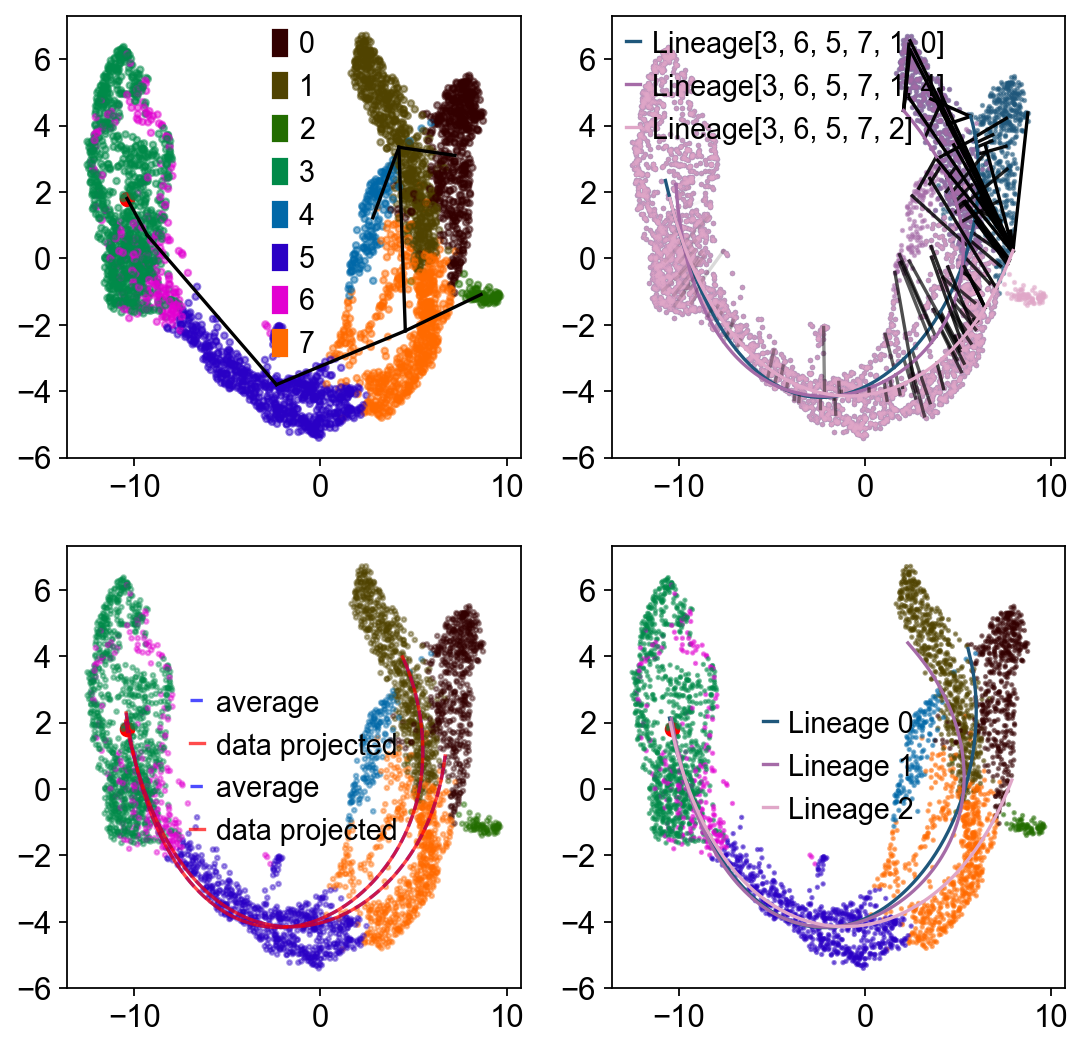

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
Traj.inference(method='slingshot',num_epochs=1,debug_axes=axes)

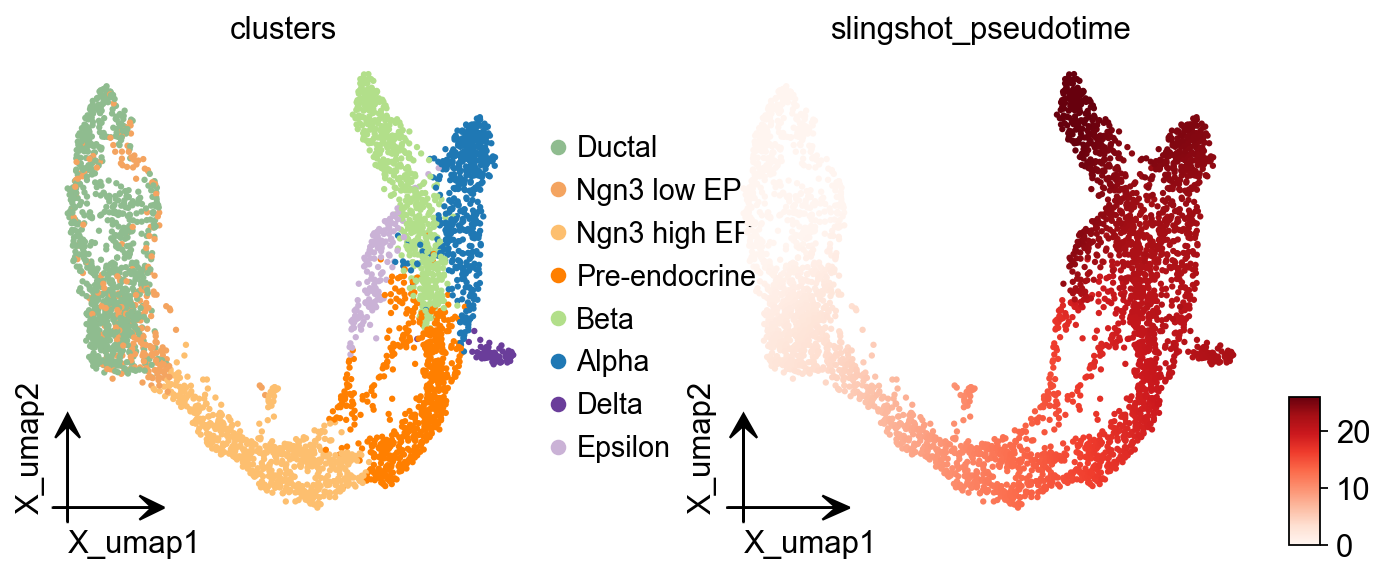

In [18]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','slingshot_pseudotime'],
                   frameon='small',cmap='Reds')

In [19]:
sc.pp.neighbors(adata,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata,use_time_prior='slingshot_pseudotime',vkey='paga',
                 groups='clusters')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['slingshot_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<Axes: title={'center': 'PAGA Slingshot-graph'}>

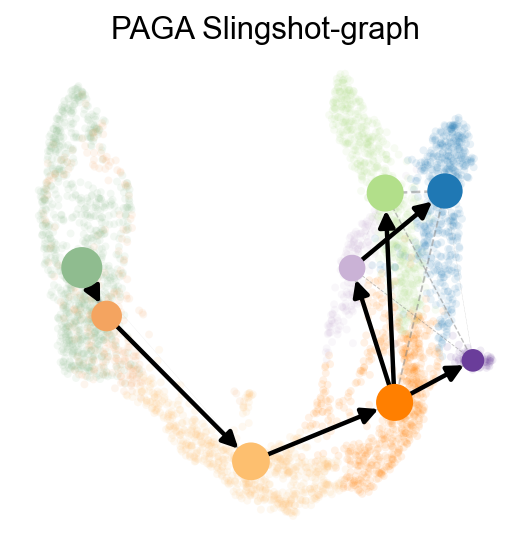

In [20]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA Slingshot-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## Palantir

Palantir can be run by specifying an approxiate early cell.

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the terminal_states parameter

Here, we used `ov.single.TrajInfer` to construct a Trajectory Inference object.

In [21]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',groupby='clusters',
                         use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('Ductal')
Traj.set_terminal_cells(["Alpha","Beta","Delta","Epsilon"])

In [22]:
Traj.inference(method='palantir',num_waypoints=500)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
**finished identifying marker genes by COSG**
Sampling and flocking waypoints...
Time for determining waypoints: 0.0012362360954284667 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 3.3117954254150392 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities..

Palantir results can be visualized on the tSNE or UMAP using the plot_palantir_results function

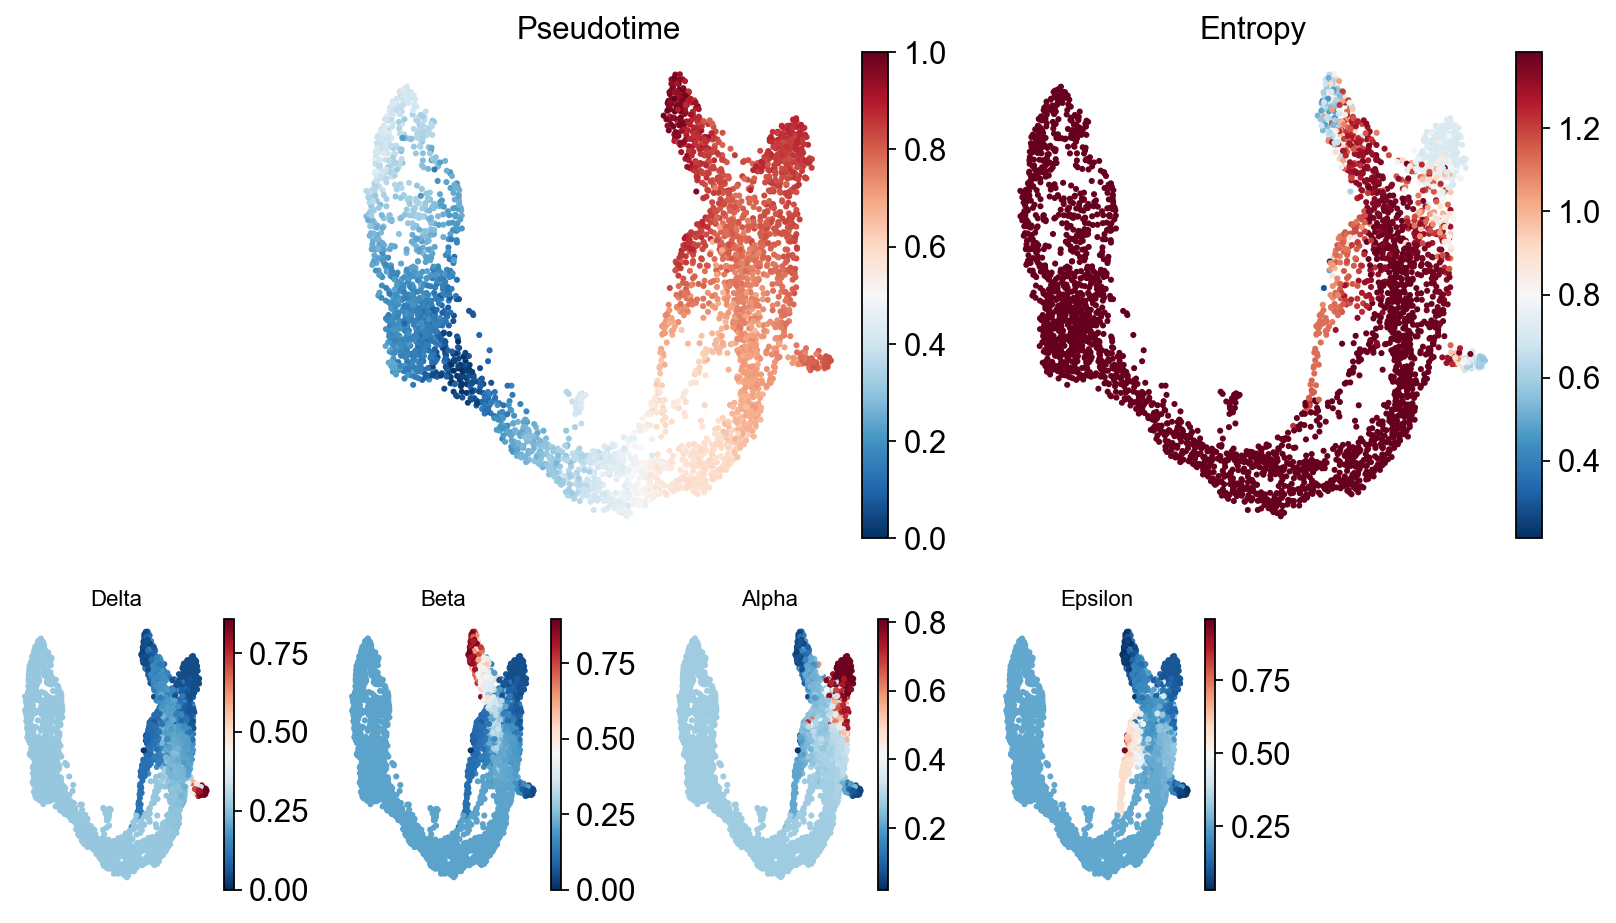

In [23]:
Traj.palantir_plot_pseudotime(embedding_basis='X_umap',cmap='RdBu_r',s=3)

Once the cells are selected, it's often helpful to visualize the selection on the pseudotime trajectory to ensure we've isolated the correct cells for our specific trend. We can do this using the plot_branch_selection function:

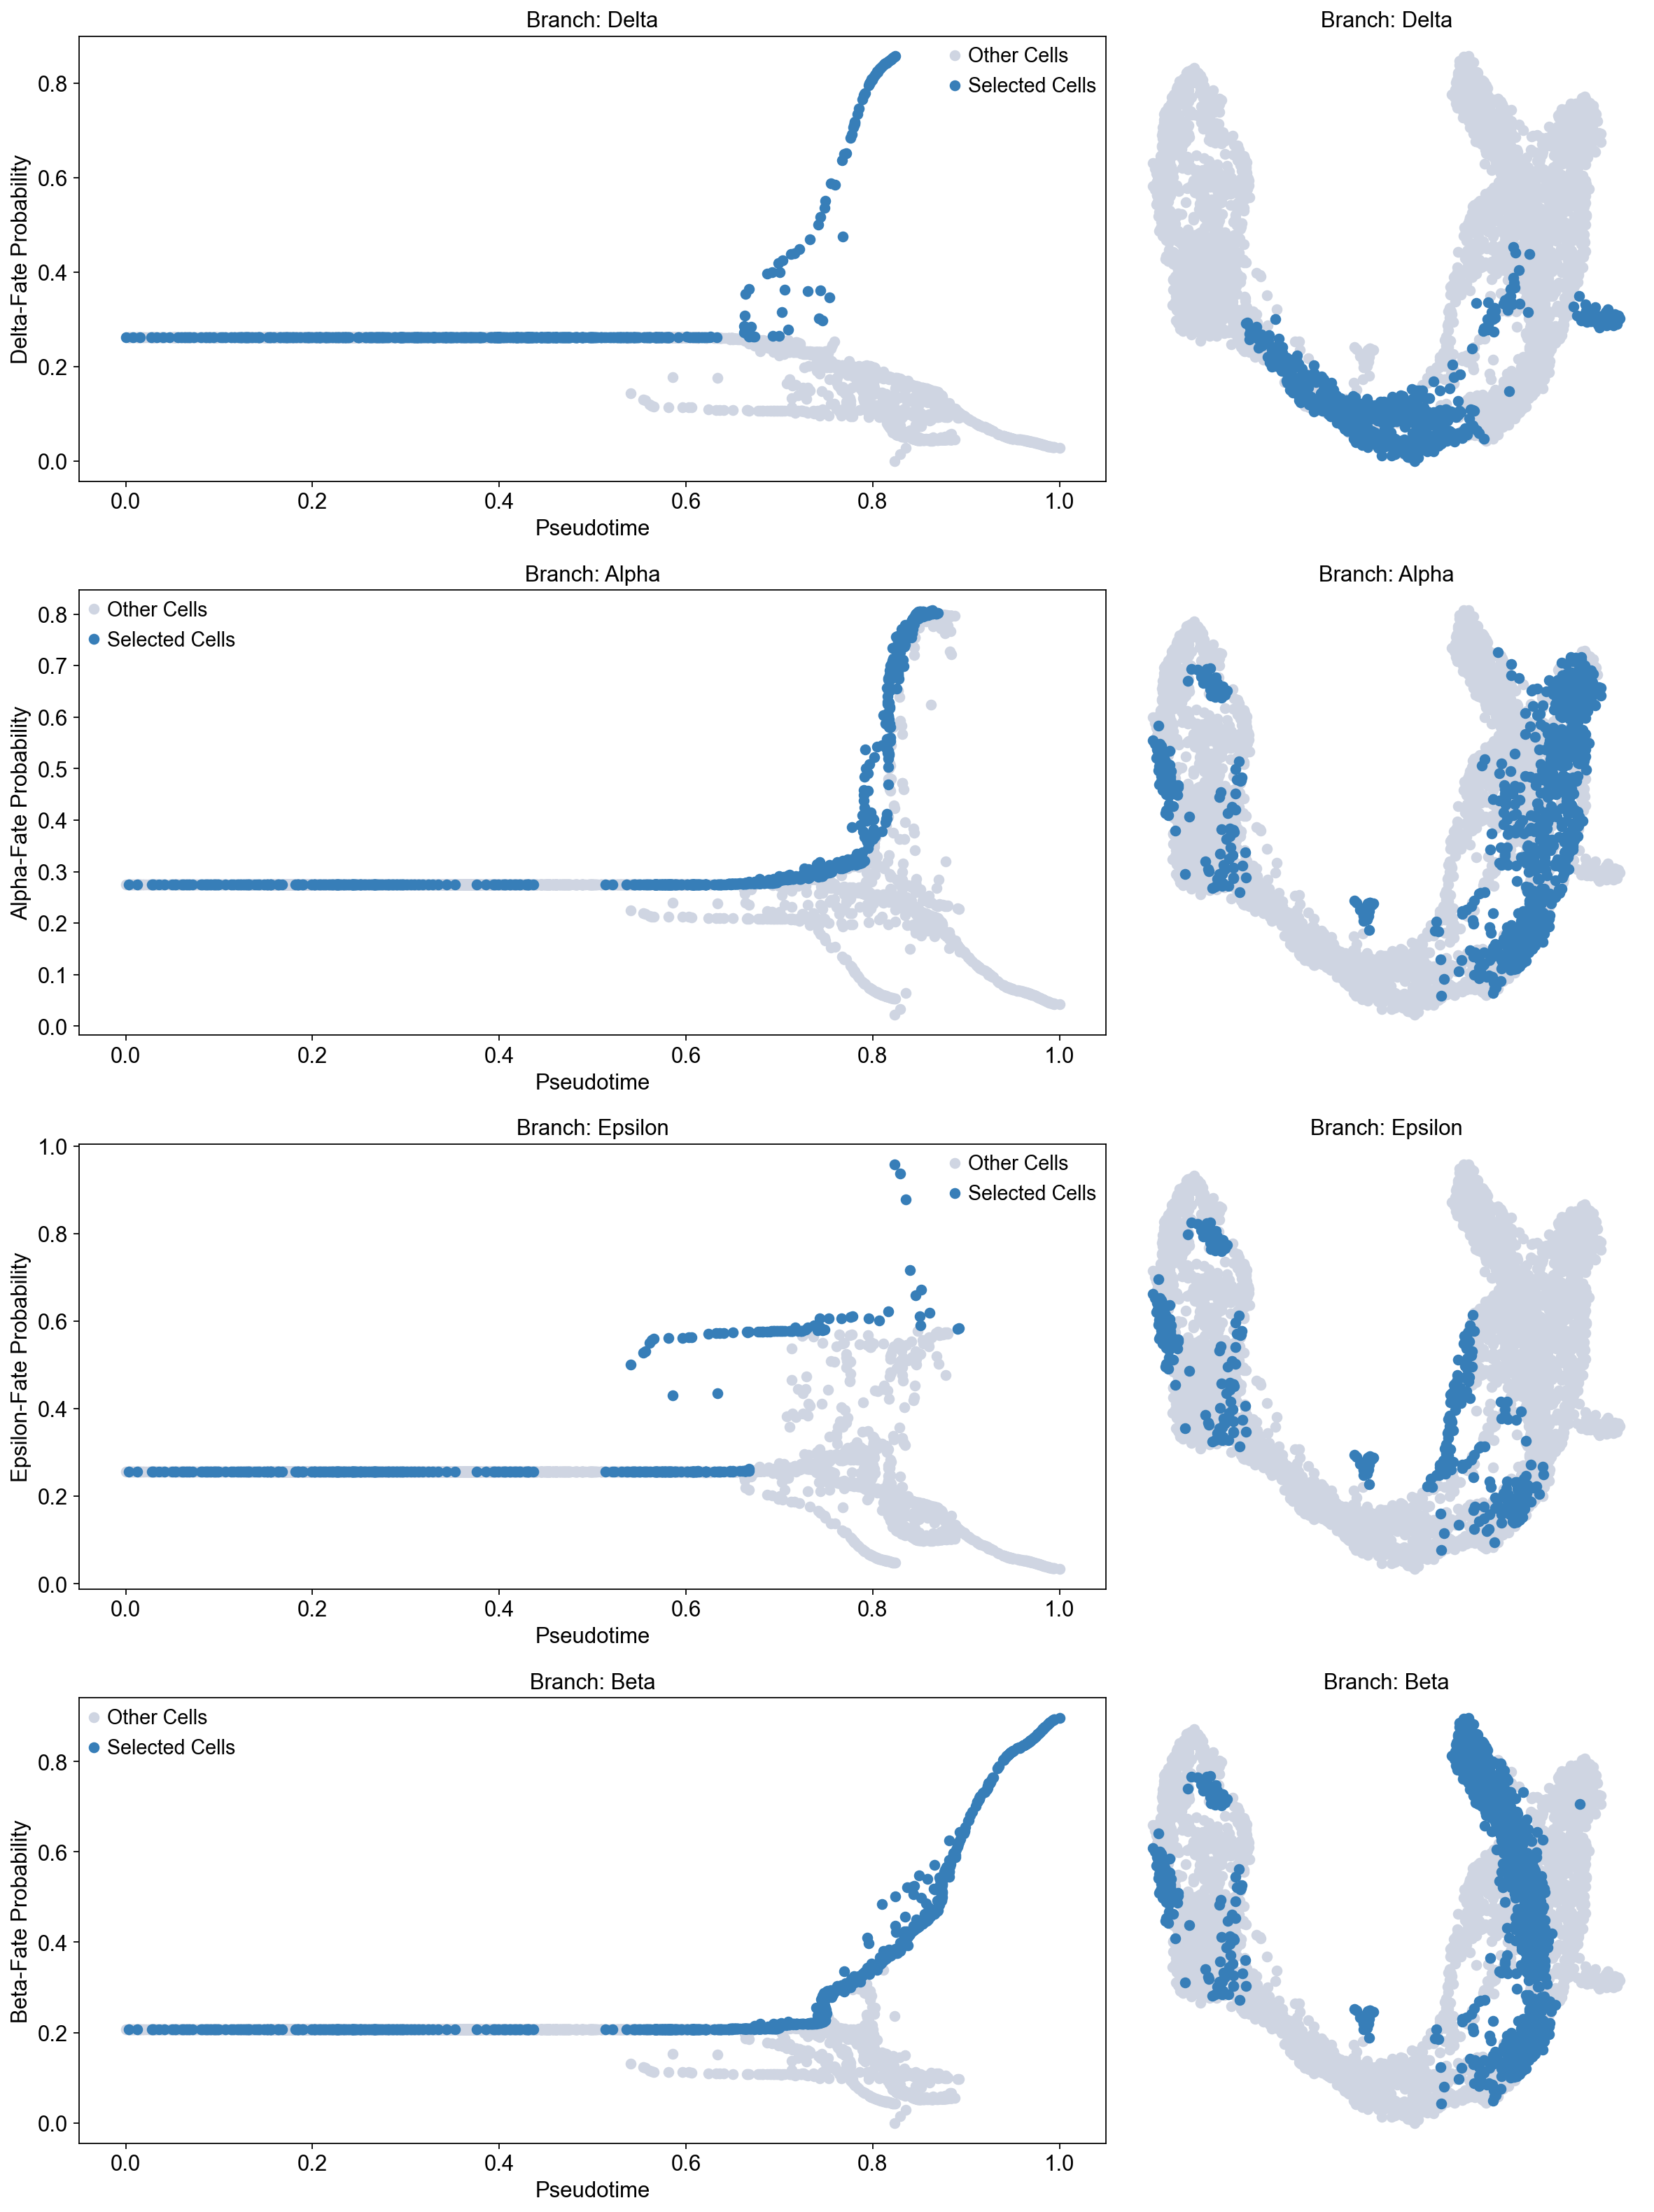

In [24]:
Traj.palantir_cal_branch(eps=0)

[2026-01-08 02:00:23,570] [INFO    ] Using sparse Gaussian Process since n_landmarks (50) < n_samples (805) and rank = 1.0.
[2026-01-08 02:00:23,571] [INFO    ] Using covariance function Matern52(ls=1.262711524963379).
[2026-01-08 02:00:23,586] [INFO    ] Computing 50 landmarks with k-means clustering (random_state=42).
[2026-01-08 02:00:24,383] [INFO    ] Sigma interpreted as element-wise standard deviation.


<Axes: title={'center': 'Branch: Alpha'}, xlabel='UMAP1', ylabel='UMAP2'>

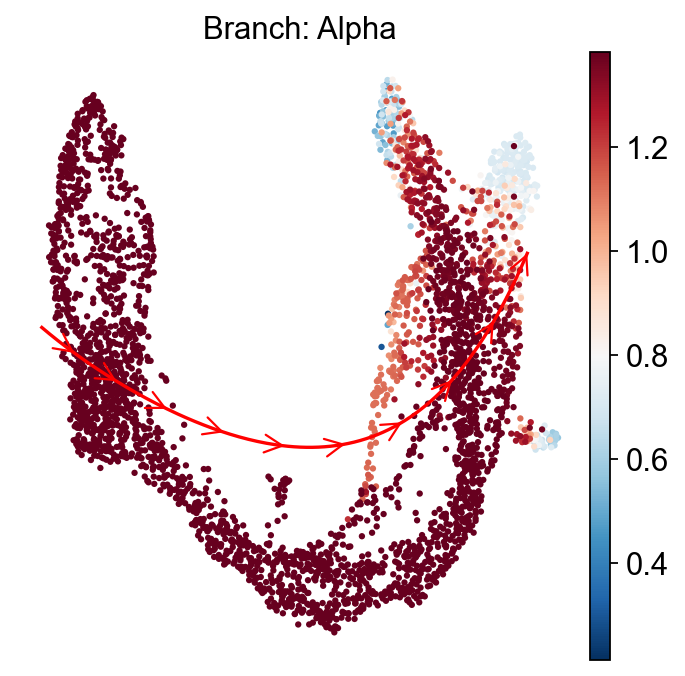

In [25]:
ov.external.palantir.plot.plot_trajectory(adata, "Alpha",
                                cell_color="palantir_entropy",
                                n_arrows=10,
                                color="red",
                                scanpy_kwargs=dict(cmap="RdBu_r"),
                                )

Palantir uses Mellon Function Estimator to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the lineages parameter.

In [26]:
adata.layers['lognorm']=adata.X.copy()
sc.external.pp.magic(adata, name_list="all_genes", knn=5)
adata.layers['MAGIC_imputed_data']=adata.X.copy()

computing MAGIC
    finished (0:00:04)


In [27]:
gene_trends = Traj.palantir_cal_gene_trends(
    layers="MAGIC_imputed_data",
)

Delta
[2026-01-08 02:00:44,451] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (624) and rank = 1.0.
[2026-01-08 02:00:44,451] [INFO    ] Using covariance function Matern52(ls=1.0).
[2026-01-08 02:00:45,253] [INFO    ] Sigma interpreted as element-wise standard deviation.
Beta
[2026-01-08 02:00:45,455] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (939) and rank = 1.0.
[2026-01-08 02:00:45,455] [INFO    ] Using covariance function Matern52(ls=1.0).
[2026-01-08 02:00:45,777] [INFO    ] Sigma interpreted as element-wise standard deviation.
Alpha
[2026-01-08 02:00:45,912] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (805) and rank = 1.0.
[2026-01-08 02:00:45,913] [INFO    ] Using covariance function Matern52(ls=1.0).
[2026-01-08 02:00:46,193] [INFO    ] Sigma interpreted as element-wise standard deviation.
Epsilon
[2026-01-08 02:00:46,308] [INFO    ] Using non-sparse Gaussian Process since n_landm

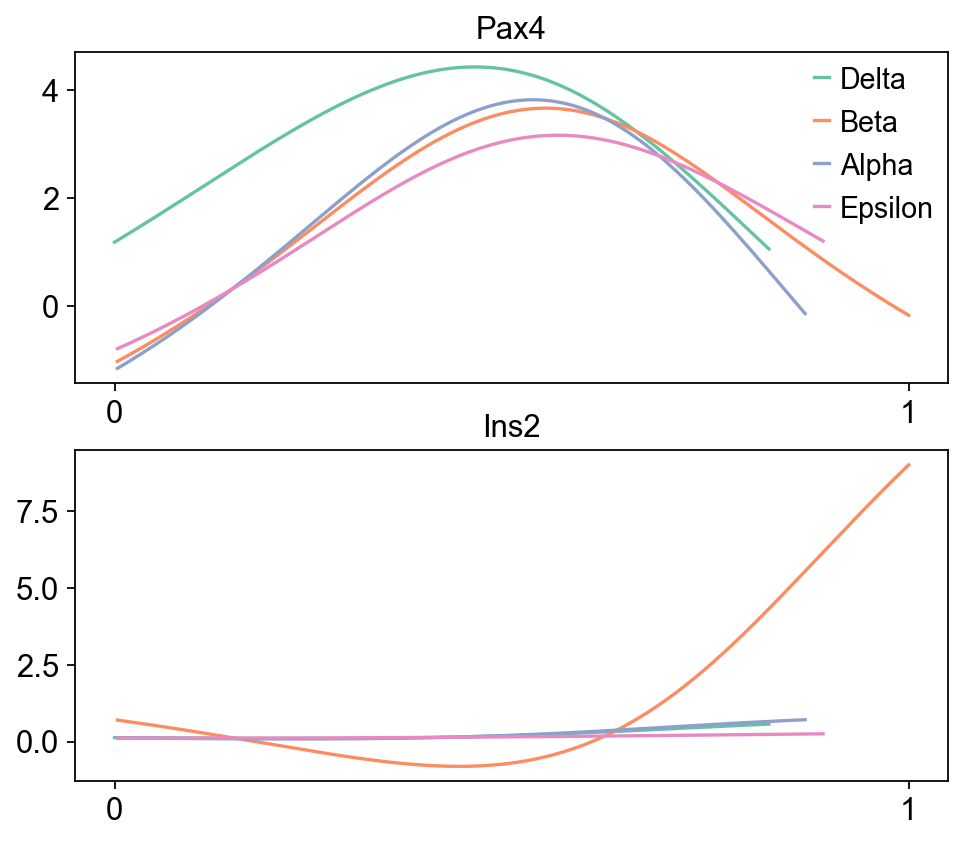

In [28]:
genes = ['Pax4','Ins2']
Traj.palantir_plot_gene_trends(genes)
plt.show()

We can also use paga to visualize the cell stages

In [29]:
ov.utils.cal_paga(adata,use_time_prior='palantir_pseudotime',vkey='paga',
                 groups='clusters')

running PAGA using priors: ['palantir_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<Axes: title={'center': 'PAGA palantir-graph'}>

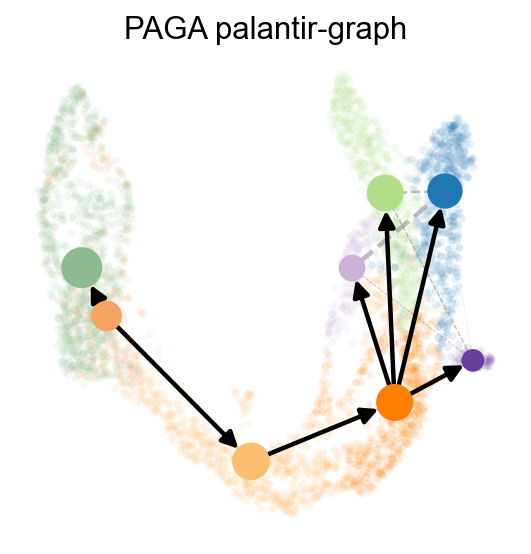

In [31]:
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA palantir-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## scTour

scTour is an innovative and comprehensive method for dissecting cellular dynamics by analysing datasets derived from single-cell genomics.

It provides a unifying framework to depict the full picture of developmental processes from multiple angles including the developmental pseudotime, vector field and latent space.

Now we are ready to train the scTour model. The default loss_mode is negative binomial conditioned likelihood (nb), which requires raw UMI counts (stored in .X of the AnnData) as input. By default, the percentage of cells used to train the model is set to 0.9 when the total number of cells is less than 10,000 and 0.2 when greater than 10,000. Users can adjust the percentage by using the parameter percent (for example percent=0.6).

In [35]:
adata.X=adata.layers['counts'].copy()
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [36]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',groupby='clusters',
                         use_rep='scaled|original|X_pca',n_comps=50)
Traj.inference(method='sctour',alpha_recon_lec=0.5, alpha_recon_lode=0.5)

Running using GPU.

poch 400: 100%|██████████| 400/400 [03:33<00:00,  1.87epoch/s, train_loss=1.31e+3, val_loss=1.31e+3]

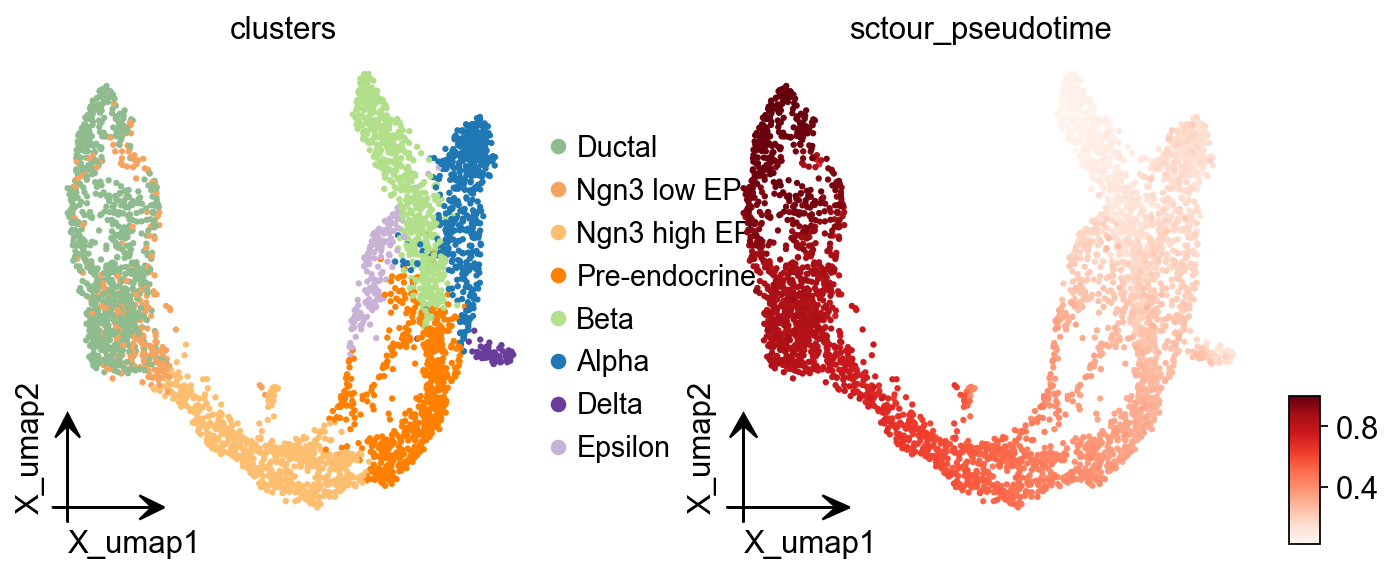

In [37]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','sctour_pseudotime'],
                   frameon='small',cmap='Reds')

In [38]:
adata.obs['sctour_pseudotime']=1-adata.obs['sctour_pseudotime']

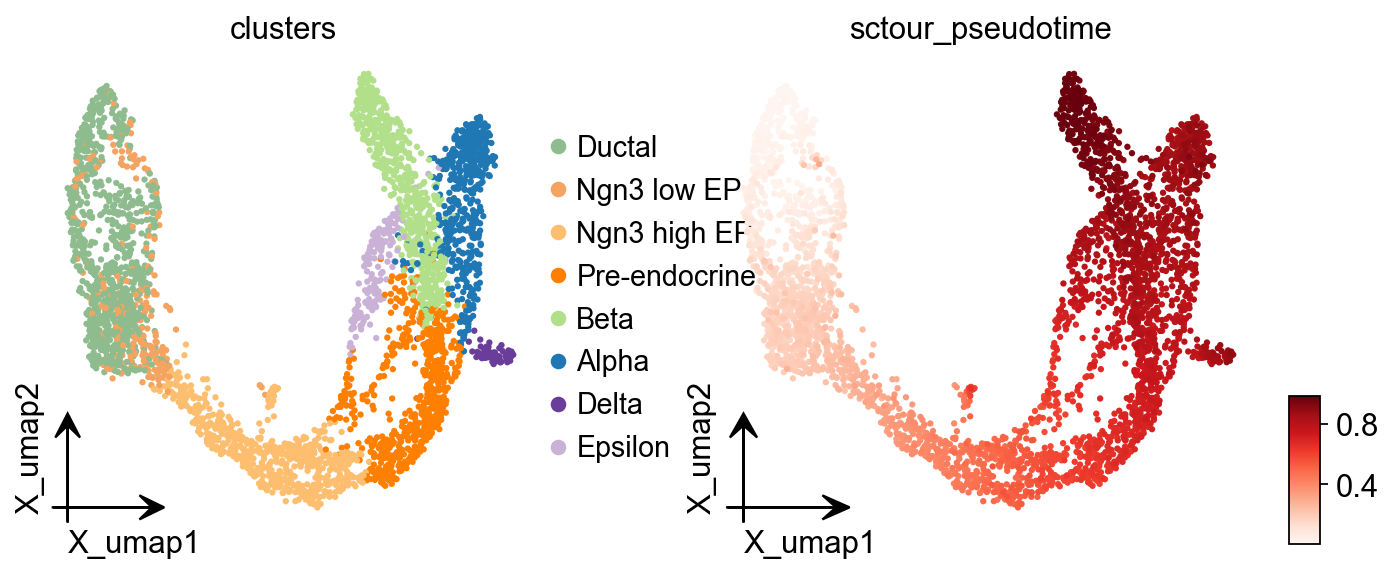

In [39]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','sctour_pseudotime'],
                   frameon='small',cmap='Reds')

In [40]:
adata.write('data/traj_tutorial.h5ad')

In [47]:
adata=ov.read('data/traj_tutorial.h5ad')